# Proyecto Viz

### Librerías utilizadas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import plotly.express as px
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve,auc
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import KNNImputer

## Análisis Exploratorio de Datos (EDA) - Fraud Detection

### Datos

In [8]:
df = pd.read_csv('dataF.csv')
print(df.head())

C:\Users\g_a09\AppData\Local\Temp\ipykernel_6340\1382054988.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dataF.csv')


   TransactionID  TransactionDT  TransactionAmt   C3   C5  card6  isFraud  \
0        2987000          86400            68.5  0.0  0.0   True    False   
1        2987001          86401            29.0  0.0  0.0   True    False   
2        2987002          86469            59.0  0.0  0.0  False    False   
3        2987003          86499            50.0  0.0  0.0  False    False   
4        2987004          86506            50.0  0.0  0.0   True    False   

   card3  card2  card4_american express  card4_discover  card4_mastercard  \
0  150.0    NaN                   False            True             False   
1  150.0  404.0                   False           False              True   
2  150.0  490.0                   False           False             False   
3  150.0  567.0                   False           False              True   
4  150.0  514.0                   False           False              True   

   card4_visa  
0       False  
1       False  
2        True  
3       Fa

Preliminarmente se observa que hay columnas tanto categoricas como numericas, donde las ultimas 4 categorias se pueden resumir en 1 sola variable que sea el tipo de compañia procesadora de pagos (AmericanExp, Discover, Mastercard, Visa).
Por otro lado la columna "TransactionDT" parece ser un registro de tiempo para cada transaccion en segundos, por conveniencia se cambiara a 1 de enero 2024 la hora mas baja, debido a que no se tiene mas informacion al respecto.

In [9]:
df_card=df.iloc[:,9:]
df_card["sum"]=df_card.sum(axis=1)
(df_card["sum"]>1).sum() 

0

Se puede confirmar que para cada fila solo existe un unico valor entre las 4 columnas, por ende esa columna puede ser agrupada en 1 sola, resultando en una variable categorica con 4 argumentos.

### Junte de columnas

In [10]:
column_dict={
    "card4_american express":"AmExp",
    "card4_discover":"Disc",
    "card4_mastercard":"MastC",
    "card4_visa":"Visa",
}
df.rename(columns=column_dict,inplace=True)

In [11]:
df["Entity"]=df.iloc[:,9:].idxmax(axis=1)

In [12]:
df.drop(df.columns[9:13],axis=1,inplace=True)
df.head(2)

,TransactionID,TransactionDT,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity
0,2987000,86400,68.5,0.0,0.0,True,False,150.0,NaN,Disc
1,2987001,86401,29.0,0.0,0.0,True,False,150.0,404.0,MastC


Se confirma que se hizo correctamente la creacion de una nueva variable que contiene la informacion de las 4 originales.

### TransactionDT a fecha

In [13]:
df.TransactionDT.isnull().sum()

0

Se confirma primero que no existan faltantes para proceder a convertir el la columna TransactionDT a fecha

In [14]:
fecha_inicio=datetime.datetime(2024,1,1)
def pasar_fechas(segs): return fecha_inicio + datetime.timedelta(seconds=segs)
df["TransactionDT"]=df["TransactionDT"].apply(pasar_fechas)
print(list(df.TransactionDT.head(10)))

[Timestamp('2024-01-02 00:00:00'), Timestamp('2024-01-02 00:00:01'), Timestamp('2024-01-02 00:01:09'), Timestamp('2024-01-02 00:01:39'), Timestamp('2024-01-02 00:01:46'), Timestamp('2024-01-02 00:01:50'), Timestamp('2024-01-02 00:02:02'), Timestamp('2024-01-02 00:02:09'), Timestamp('2024-01-02 00:02:15'), Timestamp('2024-01-02 00:02:16')]


In [15]:
df.TransactionDT.head(10)

0   2024-01-02 00:00:00
1   2024-01-02 00:00:01
2   2024-01-02 00:01:09
3   2024-01-02 00:01:39
4   2024-01-02 00:01:46
5   2024-01-02 00:01:50
6   2024-01-02 00:02:02
7   2024-01-02 00:02:09
8   2024-01-02 00:02:15
9   2024-01-02 00:02:16
Name: TransactionDT, dtype: datetime64[ns]

### Exploracion de la serie de tiempo

In [16]:
df["hora_dia"]=df["TransactionDT"].dt.hour

Se procede a crear una variable que contenga la informacion de que "hora del dia" se esta registrando la transaccion.

In [17]:
grouped = df.groupby('hora_dia').agg(
    total_transactions=pd.NamedAgg(column='isFraud', aggfunc='count'),
    fraudulent_transactions=pd.NamedAgg(column='isFraud', aggfunc='sum')
)

In [18]:
grouped['proportion'] = grouped['fraudulent_transactions'] / grouped['total_transactions']

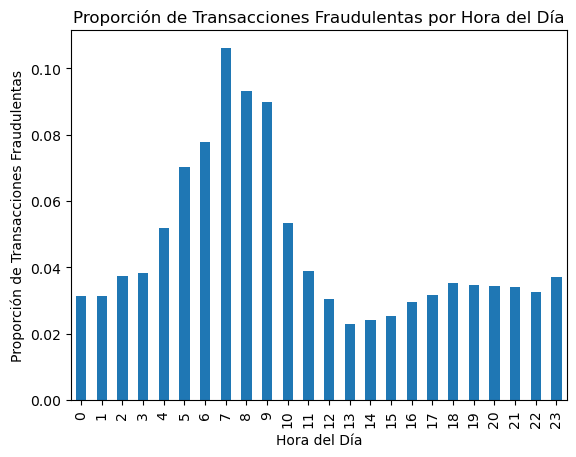

In [19]:
grouped['proportion'].plot(kind='bar', title='Proporción de Transacciones Fraudulentas por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Proporción de Transacciones Fraudulentas')
plt.show()

Se puede apreciar que hay un pico alrededor de "la hora 7" de proporcion de transacciones fraudulentas, lo que indicaria una importancia significa en la hora de la transaccion.

In [20]:
df['date'] = df['TransactionDT'].dt.date

grouped = df.groupby('date').agg(
    total_transactions=pd.NamedAgg(column='isFraud', aggfunc='count'),
    fraudulent_transactions=pd.NamedAgg(column='isFraud', aggfunc='sum')
)

grouped['fraudulent_proportion'] = grouped['fraudulent_transactions'] / grouped['total_transactions']

# Graficar la evolución de la proporción de fraudes a lo largo del tiempo
fig = px.line(grouped.reset_index(), x='date', y='fraudulent_proportion', 
              title='Evolución de la Proporción de Fraudes a lo Largo del Tiempo',
              labels={'date': 'Fecha', 'fraudulent_proportion': 'Proporción de Fraudes'},
              markers=True)

fig.show()

Aparentemente no se aprecia una tendencia entre dias ni una estacionalidad marcada, se observa ciertos picos de transacciones fraudulentas, sin embargo no parece haber un cambio de media y de varianza a lo largo de el dataset.

In [21]:
grouped.iloc[181,:]

total_transactions         2754.00000
fraudulent_transactions     119.00000
fraudulent_proportion         0.04321
Name: 2024-07-01, dtype: float64

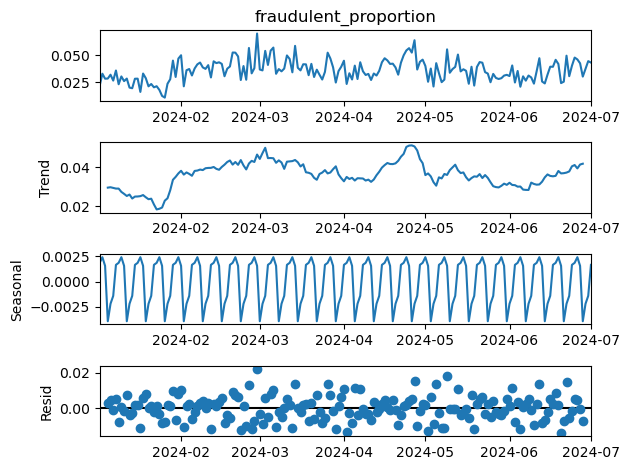

In [22]:
res = sm.tsa.seasonal_decompose(grouped['fraudulent_proportion'], period=7,model="additive")

# Graficar los componentes de la descomposición
res.plot()
plt.show()

hay una clara estacionalidad con respecto a que dia de la semana se realiza la transaccion, adicionalmente se cuenta con un crecimiento al principio de los datos que despues se mantiene un poco constante a lo largo del resto de dias del dataset.
Por otro lado podemos observar que se logra capturar un buen patron debido a que los residuos se comportan aleatoriamente al rededor de una media y varianza.

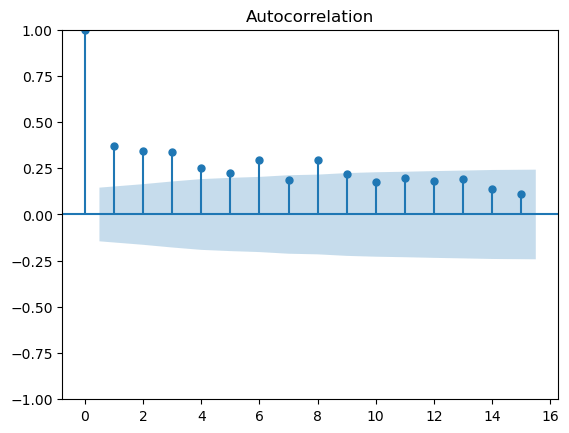

In [23]:
sm.graphics.tsa.plot_acf(grouped['fraudulent_proportion'], lags=15)
plt.show()

Al realizar la prueba de autocorrelacion podemos notar que hay un indicio de autocorrelacion cada 8 dias, lo que corresponderia al mismo dia de la semana anterior.

Como conslusion del analisis de los datos como serie de tiempo se puede confirmar que la hora del dia en el que se realiza la transaccion y el dia de la semana de dicha transaccion son datos relevantes para la prediccion de si una transaccion es fraudulenta o no.

In [24]:
df['dia_semana'] = df['TransactionDT'].dt.weekday

In [25]:
grouped = df.groupby(['dia_semana',"date"]).agg(
    total_transactions=pd.NamedAgg(column='isFraud', aggfunc='count'),
    fraudulent_transactions=pd.NamedAgg(column='isFraud', aggfunc='sum')
)
grouped['fraudulent_proportion'] = grouped['fraudulent_transactions'] / grouped['total_transactions']


In [26]:
fig = px.box(grouped.reset_index(), x='dia_semana', y='fraudulent_proportion',
             title='Proporción de Fraudes por Día de la Semana',
             labels={'dia_de_la_semana': 'Día de la Semana', 'fraudulent_proportion': 'Proporción de Fraudes'})

fig.show()

Se encuentra que existe patrones de comportamiento de proporcion de fraudes distintos para cada dia.


In [27]:
len(df)

590540

## Datos faltantes


In [29]:
df.head()

,TransactionID,TransactionDT,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date,dia_semana
0,2987000,2024-01-02 00:00:00,68.5,0.0,0.0,True,False,150.0,NaN,Disc,0,2024-01-02,1
1,2987001,2024-01-02 00:00:01,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02,1
2,2987002,2024-01-02 00:01:09,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02,1
3,2987003,2024-01-02 00:01:39,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02,1
4,2987004,2024-01-02 00:01:46,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02,1


Dado que ya se extrajo la mayor cantidad de informacion util de la columna "TransactionDT", se eliminara. Por otro lado el Id de la transaccion tambien sera removida debido a que no aporta nada para predecir.

In [31]:
df_new=df.drop(["TransactionID","TransactionDT"],axis=1)
df_new.head()

,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date,dia_semana
0,68.5,0.0,0.0,True,False,150.0,NaN,Disc,0,2024-01-02,1
1,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02,1
2,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02,1
3,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02,1
4,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02,1


In [26]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionAmt  590540 non-null  float64
 1   C3              590540 non-null  float64
 2   C5              590540 non-null  float64
 3   card6           588924 non-null  object 
 4   isFraud         590540 non-null  bool   
 5   card3           588975 non-null  float64
 6   card2           581607 non-null  float64
 7   Entity          590540 non-null  object 
 8   hora_dia        590540 non-null  int64  
 9   date            590540 non-null  object 
 10  dia_semana      590540 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 45.6+ MB


Se puede apreciar algunas columnas con faltantes, la columna "card6" que es una columna boleana esta como objeto, se procedera a hacer la transformacion.

In [32]:
df_new["date"]=pd.to_datetime(df_new["date"])
df_new["card6"]=df_new["card6"].astype(bool)

In [33]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   TransactionAmt  590540 non-null  float64       
 1   C3              590540 non-null  float64       
 2   C5              590540 non-null  float64       
 3   card6           590540 non-null  bool          
 4   isFraud         590540 non-null  bool          
 5   card3           588975 non-null  float64       
 6   card2           581607 non-null  float64       
 7   Entity          590540 non-null  object        
 8   hora_dia        590540 non-null  int64         
 9   date            590540 non-null  datetime64[ns]
 10  dia_semana      590540 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 41.7+ MB


Ahora las columnas son reconocidad correctamente por el tipo de dato que tienen.

In [34]:
cols_w_nan=[col for col in df.columns if df[col].isnull().any()]
cols_w_nan

['card6', 'card3', 'card2']

Solo las columnas card3 y card2 presentan datos faltantes, se procede a revisar si representan un % alto de los registros.

In [35]:
df_new.isnull().any(axis=1).sum()

8933

Existen 8933 filas con almenos 1 valor en NAN.

In [36]:
prop_nan=(df_new.isnull().any(axis=1).sum()/len(df_new))*100
prop_nan

1.5126833068039423

los valores faltantes representan aproximadamete el 1.5% de los registros.

In [37]:
a=df_new.isnull().any(axis=1)
b=a[a==True]
c=list(b.index)

d=df_new.iloc[c,:]

In [38]:
d["card2"].isnull().sum()

8933

In [39]:
nfraud=len(d[d["isFraud"]==True])
nnotfraud=len(d[d["isFraud"]==False])

print("porcentaje de valores faltantes que son fraudes", (nfraud)*100/(nfraud+nnotfraud) ,"que no lo son",(nnotfraud)*100/(nfraud+nnotfraud) )

porcentaje de valores faltantes que son fraudes 4.735251315347588 que no lo son 95.26474868465242


In [40]:
nfraud=len(df_new[df_new["isFraud"]==True])
nnotfraud=len(df_new[df_new["isFraud"]==False])
print( (nfraud)*100/(nfraud+nnotfraud) ,"que no lo son",(nnotfraud)*100/(nfraud+nnotfraud) )

3.499000914417313 que no lo son 96.50099908558269


Se puede ver que mas o menos se conserva la proporcion de faltantes de valores de fraud y no fraud entre los que tienen datos faltante y lo que no tienen datos faltantes.

In [41]:
a=df_new[df_new["card2"].isnull()]

nfraud=len(a[a["isFraud"]==True])
nnotfraud=len(a[a["isFraud"]==False])
print( (nfraud)*100/(nfraud+nnotfraud) ,"que no lo son",(nnotfraud)*100/(nfraud+nnotfraud) )


4.735251315347588 que no lo son 95.26474868465242


Se mantiene la relacion inicial.

In [37]:
a=df_new[df_new["card3"].isnull()]

nfraud=len(a[a["isFraud"]==True])
nnotfraud=len(a[a["isFraud"]==False])
print( (nfraud)*100/(nfraud+nnotfraud) ,"que no lo son",(nnotfraud)*100/(nfraud+nnotfraud) )

2.4920127795527156 que no lo son 97.50798722044729


se puede observar que hay un poco mas de presencia de valores faltantantes para transacciones no fraudulentas que para las fraudulentas en la columna card3.

Se procede a realizar una tecnica de KNN-Imputation para los datos faltantes.


In [42]:
df.head(
    
)

,TransactionID,TransactionDT,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date,dia_semana
0,2987000,2024-01-02 00:00:00,68.5,0.0,0.0,True,False,150.0,NaN,Disc,0,2024-01-02,1
1,2987001,2024-01-02 00:00:01,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02,1
2,2987002,2024-01-02 00:01:09,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02,1
3,2987003,2024-01-02 00:01:39,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02,1
4,2987004,2024-01-02 00:01:46,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02,1


In [43]:
imputer=KNNImputer(n_neighbors=2)

numeric_df = df.select_dtypes(include=['number'])
categorical_df = df.select_dtypes(exclude=['number'])

numeric_df_imputed = pd.DataFrame(imputer.fit_transform(numeric_df), columns=numeric_df.columns)

df2 = pd.concat([numeric_df_imputed, categorical_df], axis=1)


In [44]:
df2.head()

,TransactionID,TransactionAmt,C3,C5,card3,card2,hora_dia,dia_semana,TransactionDT,card6,isFraud,Entity,date
0,2987000.0,68.5,0.0,0.0,150.0,522.5,0.0,1.0,2024-01-02 00:00:00,True,False,Disc,2024-01-02
1,2987001.0,29.0,0.0,0.0,150.0,404.0,0.0,1.0,2024-01-02 00:00:01,True,False,MastC,2024-01-02
2,2987002.0,59.0,0.0,0.0,150.0,490.0,0.0,1.0,2024-01-02 00:01:09,False,False,Visa,2024-01-02
3,2987003.0,50.0,0.0,0.0,150.0,567.0,0.0,1.0,2024-01-02 00:01:39,False,False,MastC,2024-01-02
4,2987004.0,50.0,0.0,0.0,150.0,514.0,0.0,1.0,2024-01-02 00:01:46,True,False,MastC,2024-01-02


In [45]:
df.to_csv("DataF_2.csv",index=False)

## Eda Variables numericas y categoricas

In [7]:
df_new=pd.read_csv("DataF_2.csv")
df_new.head()

C:\Users\g_a09\AppData\Local\Temp\ipykernel_9948\1234892607.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_new=pd.read_csv("DataF_2.csv")


,TransactionID,TransactionDT,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date,dia_semana
0,2987000,2024-01-02 00:00:00,68.5,0.0,0.0,True,False,150.0,NaN,Disc,0,2024-01-02,1
1,2987001,2024-01-02 00:00:01,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02,1
2,2987002,2024-01-02 00:01:09,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02,1
3,2987003,2024-01-02 00:01:39,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02,1
4,2987004,2024-01-02 00:01:46,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02,1


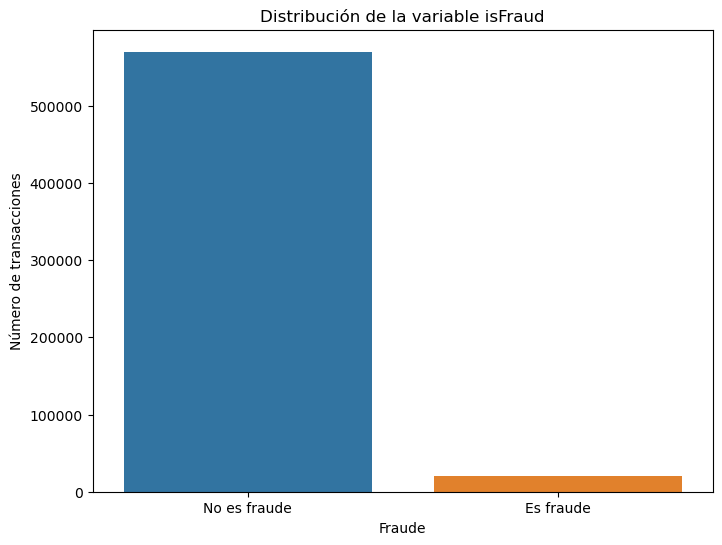

In [5]:
fraude = {False: 'No es fraude', True: 'Es fraude'}

df_b = df['isFraud'].map(fraude)

plt.figure(figsize=(8, 6))
sns.countplot(x=df_b)
plt.xlabel('Fraude')
plt.ylabel('Número de transacciones')
plt.title('Distribución de la variable isFraud')
plt.show()

Se observa que la mayoría de datos en el datset corresponde a la categoría ‘No es fraude’, mientras que hay muchos menos datos de la categoría ‘Es fraude’. Esto significa que tenemos un conjunto de datos desbalanceados.

In [31]:
df_new.head()

,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date
0,68.5,0.0,0.0,True,False,150.0,NaN,Disc,0,2024-01-02
1,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02
2,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02
3,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02
4,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02


In [46]:
df_new=df_new.dropna()

In [56]:
df_new.head()

,TransactionAmt,C3,C5,card6,isFraud,card3,card2,Entity,hora_dia,date,dia_semana
1,29.0,0.0,0.0,True,False,150.0,404.0,MastC,0,2024-01-02,1
2,59.0,0.0,0.0,False,False,150.0,490.0,Visa,0,2024-01-02,1
3,50.0,0.0,0.0,False,False,150.0,567.0,MastC,0,2024-01-02,1
4,50.0,0.0,0.0,True,False,150.0,514.0,MastC,0,2024-01-02,1
5,49.0,0.0,0.0,False,False,150.0,555.0,Visa,0,2024-01-02,1


In [8]:
df_n_num=df_new.select_dtypes(include="float")
df_n_num["isFraud"]=df_new["isFraud"]

cols=["Entity","card6","isFraud"]
df_n_cat=df_new.loc[:,cols]

In [53]:
df_n_num.head()

,TransactionAmt,C3,C5,card3,card2,isFraud
1,29.0,0.0,0.0,150.0,404.0,False
2,59.0,0.0,0.0,150.0,490.0,False
3,50.0,0.0,0.0,150.0,567.0,False
4,50.0,0.0,0.0,150.0,514.0,False
5,49.0,0.0,0.0,150.0,555.0,False


In [60]:
df_n_cat.head()

,Entity,card6,isFraud
1,MastC,True,False
2,Visa,False,False
3,MastC,False,False
4,MastC,True,False
5,Visa,False,False


### Numericas

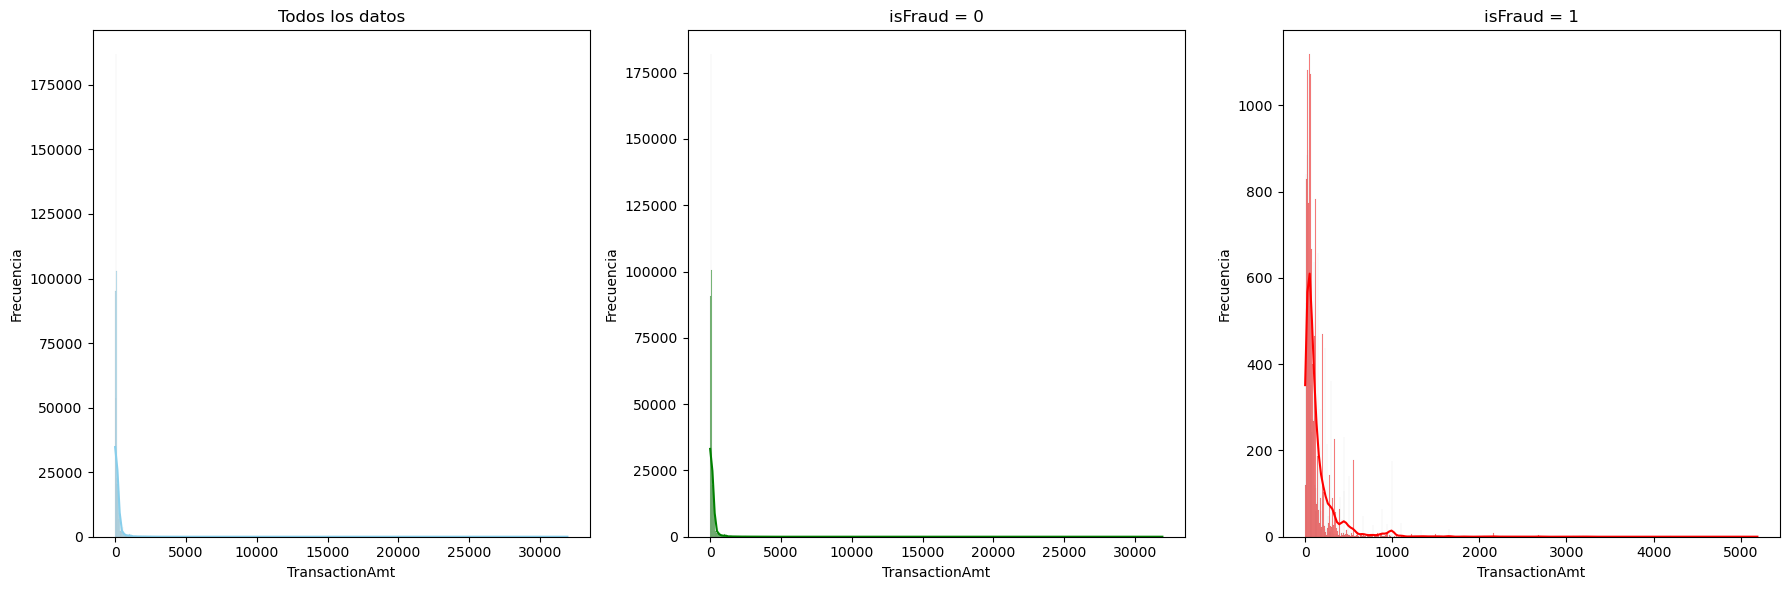

In [71]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma con todos los datos
sns.histplot(df_n_num["TransactionAmt"], bins=1000, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 0
sns.histplot(df_n_num[df_n_num["isFraud"] == False]["TransactionAmt"], bins=1000, kde=True, color='green', ax=axes[1])
axes[1].set_title('isFraud = 0')
axes[1].set_xlabel('TransactionAmt')
axes[1].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 1
sns.histplot(df_n_num[df_n_num['isFraud'] == True]["TransactionAmt"], bins=1000, kde=True, color='red', ax=axes[2])
axes[2].set_title('isFraud = 1')
axes[2].set_xlabel('TransactionAmt')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()  
plt.show()

poco valores muy altos, se analiza si los muy alto tienen alguna incidencia en el fraude.

In [9]:
a=df_n_num["TransactionAmt"]
b=list(a.quantile([0.025,0.975]))

In [10]:
c=df_n_num[(df_n_num["TransactionAmt"]<b[1]) & (df_n_num["TransactionAmt"]>b[0])][["TransactionAmt","isFraud"]]
c

,TransactionAmt,isFraud
0,68.50,False
1,29.00,False
2,59.00,False
3,50.00,False
4,50.00,False
...,...,...
590535,49.00,False
590536,39.50,False
590537,30.95,False
590538,117.00,False


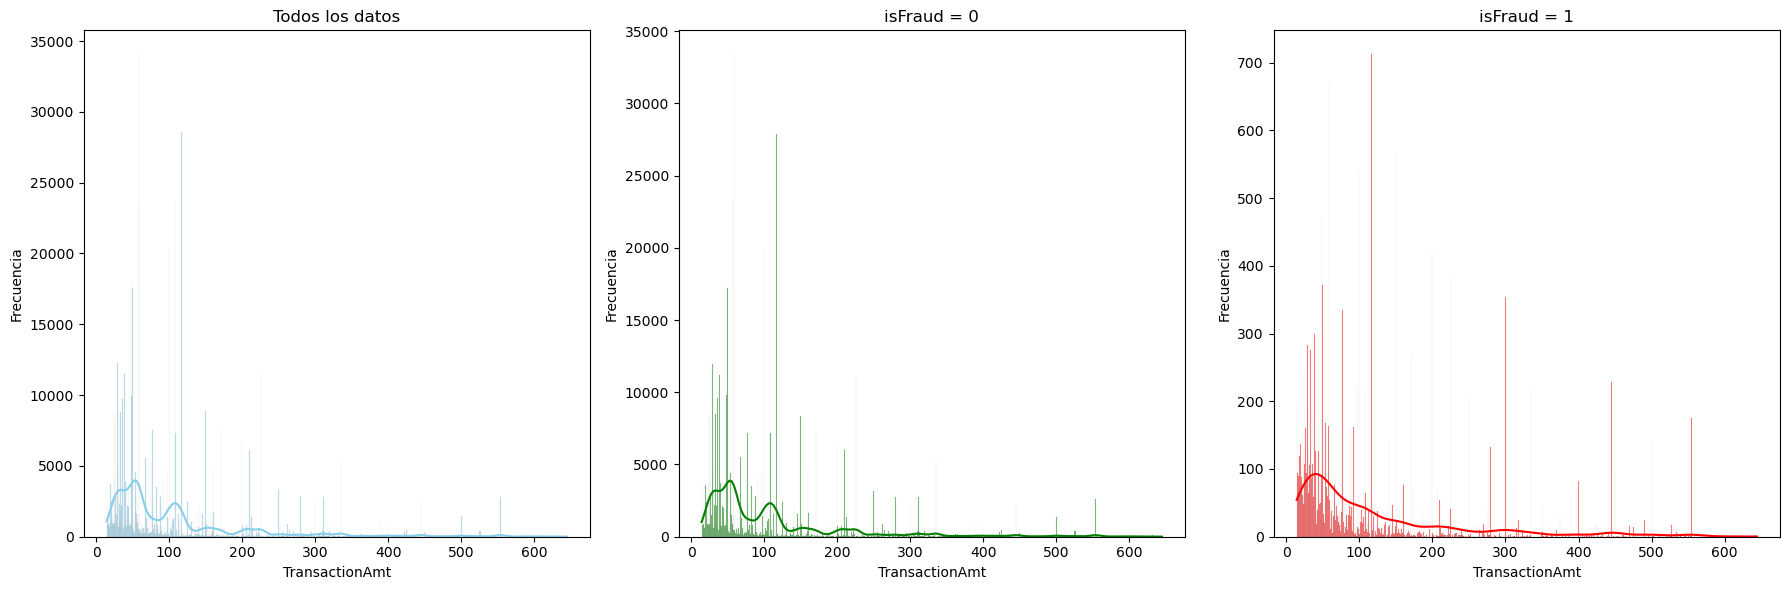

In [108]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histograma con todos los datos
sns.histplot(c["TransactionAmt"], bins=1000, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 0
sns.histplot(c[c["isFraud"] == False]["TransactionAmt"], bins=1000, kde=True, color='green', ax=axes[1])
axes[1].set_title('isFraud = 0')
axes[1].set_xlabel('TransactionAmt')
axes[1].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 1
sns.histplot(c[c['isFraud'] == True]["TransactionAmt"], bins=1000, kde=True, color='red', ax=axes[2])
axes[2].set_title('isFraud = 1')
axes[2].set_xlabel('TransactionAmt')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()  
plt.show()

Se puede observar que para las transacciones no fraudulentas hay bayes en datos al rededor de 80 y 130, por el contrario las transacciones fraudulentas si presentan una frecuencia proporcional de estos, indicando que podria haber relevancia en cuanto al valor de TransactionAmt.

Se aprecia curvas semejantes a la distribucion exponencial.

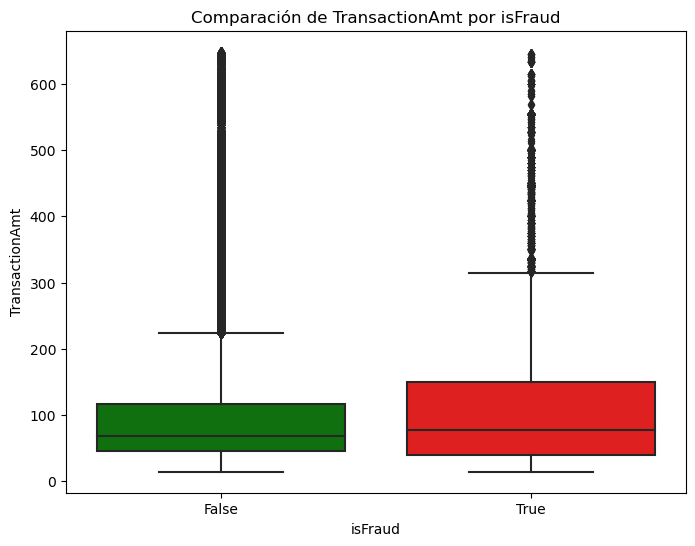

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Crear un boxplot para comparar 'TransactionAmt' según 'isFraud'
# Dado que 'isFraud' es una variable categórica, lo usamos como eje x
sns.boxplot(data=c, x='isFraud', y='TransactionAmt', ax=ax, palette=['green', 'red'])

# Añadir títulos y etiquetas
ax.set_title('Comparación de TransactionAmt por isFraud')
ax.set_xlabel('isFraud')
ax.set_ylabel('TransactionAmt')

plt.show()

Se puede apreciar que para los casos de fraude, los valores de TransactionAmt tienden a ser mayores que cuando no hay fraude. 

In [110]:
d=df_n_num[df_n_num["TransactionAmt"]>b[1]][["TransactionAmt","isFraud"]]

Se crea otro Df con la informacion de TransactionAmt con valores mayores al percentil 2.5.

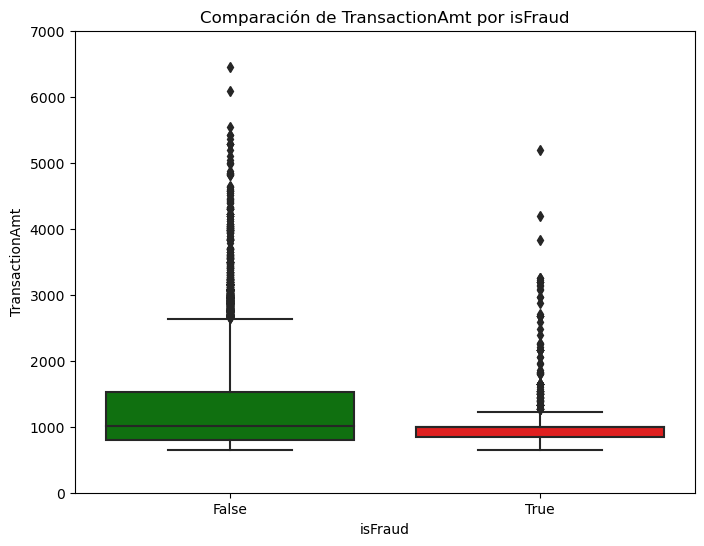

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Crear un boxplot para comparar 'TransactionAmt' según 'isFraud'
# Dado que 'isFraud' es una variable categórica, lo usamos como eje x
sns.boxplot(data=d, x='isFraud', y='TransactionAmt', ax=ax, palette=['green', 'red'] )
ax.set_ylim(0,7000)

# Añadir títulos y etiquetas
ax.set_title('Comparación de TransactionAmt por isFraud')
ax.set_xlabel('isFraud')
ax.set_ylabel('TransactionAmt')

plt.show()

Se puede observar que las transacciones que no son fraude presentan una distribucion mucho mas amplia que las transacciones que si, se  puede ver que la media se encuentra cerca del percentir 75 de Fraude y valores mas altos en general.

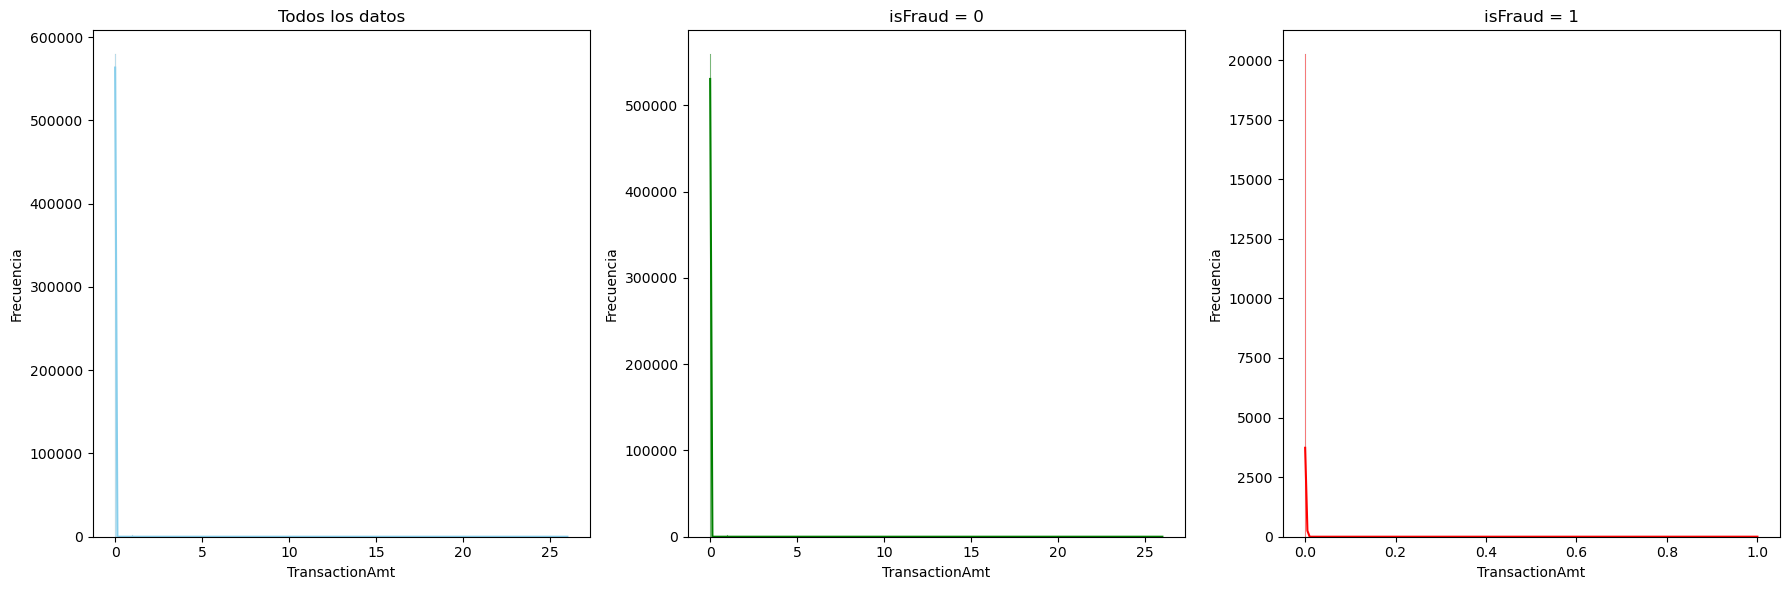

In [115]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_n_num["C3"], bins=1000, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 0
sns.histplot(df_n_num[df_n_num["isFraud"] == False]["C3"], bins=1000, kde=True, color='green', ax=axes[1])
axes[1].set_title('isFraud = 0')
axes[1].set_xlabel('TransactionAmt')
axes[1].set_ylabel('Frecuencia')

# Histograma donde la columna isFraud = 1
sns.histplot(df_n_num[df_n_num['isFraud'] == True]["C3"], bins=1000, kde=True, color='red', ax=axes[2])
axes[2].set_title('isFraud = 1')
axes[2].set_xlabel('TransactionAmt')
axes[2].set_ylabel('Frecuencia')

plt.tight_layout()  
plt.show()

Se observa que la gran parte de los datos se concentran en 0, adicional se ve que las transacciones no fraudulentas tienen algunos datos que crecen hasta 25, en cambio los de fraude siempre se mantienen entre 0 y 1.

In [121]:
df_n_num["C3"].quantile([0.025,0.975])

0.025    0.0
0.975    0.0
Name: C3, dtype: float64

Como descrito previamente, la mayoria de datos corresponden al valor de 0.

In [138]:
df_n_num[df_n_num["isFraud"]==True]["C3"].quantile([0.025,0.999])

0.025    0.0
0.999    0.0
Name: C3, dtype: float64

In [139]:
df_n_num[df_n_num["isFraud"]==False]["C3"].quantile([0.025,0.999])

0.025    0.0
0.999    1.0
Name: C3, dtype: float64

In [143]:
n=len(df_n_num[(df_n_num["isFraud"]==False) & (df_n_num["C3"]>=1)])
m=len(df_n_num[(df_n_num["isFraud"]==True) & (df_n_num["C3"]>=1)])
print(n/(n+m))

0.9979330301777594


teniendo en cuenta que los fraudes se mueven entre 0 y 1, si la transaccion presenta valores de 1 o mas, en el 99,8% de las veces no es fraudulenta.

In [145]:
n=len(df_n_num[(df_n_num["isFraud"]==False)])
m=len(df_n_num[(df_n_num["isFraud"]==True)])
print(n/(n+m))

0.9651998686398203


La proporcion de no fraudes cambia al analizar todos los datos.

In [124]:
e=df_n_num[df_n_num.C3 != 0][["C3","isFraud"]]
df_n_num["C3"].value_counts()


0.0     579188
1.0       2127
2.0        180
3.0         58
4.0          7
16.0         6
9.0          5
11.0         5
5.0          3
13.0         3
14.0         3
7.0          2
17.0         2
15.0         2
12.0         2
10.0         2
8.0          2
18.0         1
19.0         1
20.0         1
21.0         1
22.0         1
23.0         1
24.0         1
25.0         1
6.0          1
26.0         1
Name: C3, dtype: int64

De los 580.000 datos que se cuentan se tiene que casi todos tienen valores de 0 y con unos cuantos casos atipicos que cuentan con otro valor, los cuales son enteros.

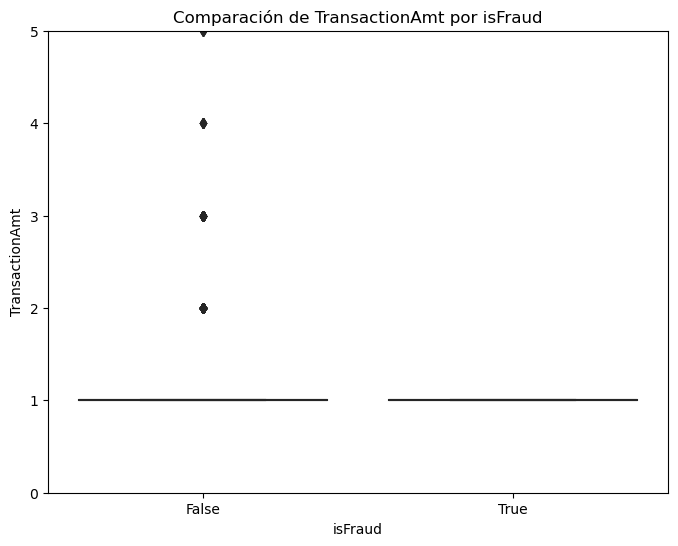

In [129]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Crear un boxplot para comparar 'TransactionAmt' según 'isFraud'
# Dado que 'isFraud' es una variable categórica, lo usamos como eje x
sns.boxplot(data=e, x='isFraud', y='C3', ax=ax, palette=['green', 'red'] )
ax.set_ylim(0,5)

# Añadir títulos y etiquetas
ax.set_title('Comparación de TransactionAmt por isFraud')
ax.set_xlabel('isFraud')
ax.set_ylabel('TransactionAmt')

plt.show()

Omitiendo el valor de 0, se puede observar que los datos que son mayores a 1 son no fraudulentas.

In [151]:
df_n_num["C5"].quantile([0.025,0.975])

0.025    150.0
0.975    185.0
Name: card3, dtype: float64

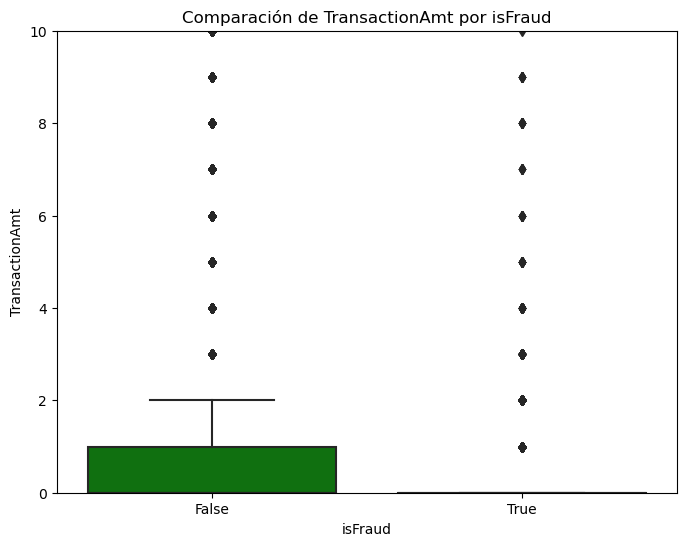

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Crear un boxplot para comparar 'TransactionAmt' según 'isFraud'
# Dado que 'isFraud' es una variable categórica, lo usamos como eje x
sns.boxplot(data=df_n_num, x='isFraud', y='C5', ax=ax, palette=['green', 'red'] )
ax.set_ylim(0,10)

# Añadir títulos y etiquetas
ax.set_title('Comparación de TransactionAmt por isFraud')
ax.set_xlabel('isFraud')
ax.set_ylabel('TransactionAmt')

plt.show()

In [158]:
df_n_num["card3"].value_counts()

150.0    514142
185.0     56345
106.0      1571
144.0      1245
146.0      1230
          ...  
125.0         1
101.0         1
199.0         1
132.0         1
173.0         1
Name: card3, Length: 109, dtype: int64

La gran mayoria de datos tienen valores de 150 y 185.

In [149]:
df_n_num["card3"].quantile([0.025,0.975])

0.025    150.0
0.975    185.0
Name: card3, dtype: float64

In [152]:
df_n_num[df_n_num["isFraud"]==False]["card3"].quantile([0.025,0.975])

0.025    150.0
0.975    185.0
Name: card3, dtype: float64

In [153]:
df_n_num[df_n_num["isFraud"]==True]["card3"].quantile([0.025,0.975])

0.025    150.0
0.975    185.0
Name: card3, dtype: float64

el 95% de los datos estan presentes en 150 y 185, tanto para transacciones no fraudulentas como las fraudulentas.

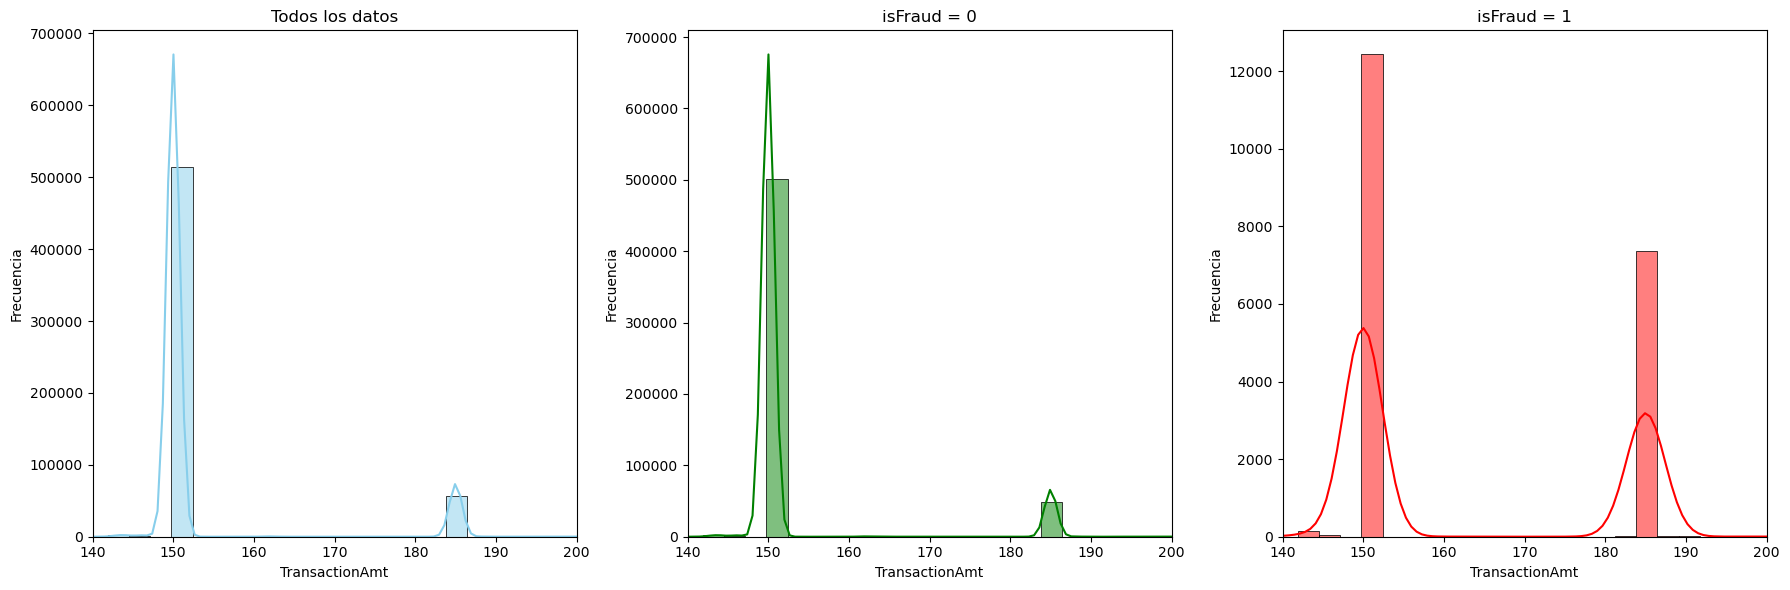

In [157]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_n_num["card3"], bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('Frecuencia')
axes[0].set_xlim(140, 200)

# Histograma donde la columna isFraud = 0
sns.histplot(df_n_num[df_n_num["isFraud"] == False]["card3"], bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title('isFraud = 0')
axes[1].set_xlabel('TransactionAmt')
axes[1].set_ylabel('Frecuencia')
axes[1].set_xlim(140, 200)

# Histograma donde la columna isFraud = 1
sns.histplot(df_n_num[df_n_num['isFraud'] == True]["card3"], bins=50, kde=True, color='red', ax=axes[2])
axes[2].set_title('isFraud = 1')
axes[2].set_xlabel('TransactionAmt')
axes[2].set_ylabel('Frecuencia')
axes[2].set_xlim(140, 200)

plt.tight_layout()  
plt.show()

Las transacciones fraudulentas presentan una gran proporcion para el valor 185, con respecto a la proporcion de los que no son fraude.

In [159]:
n=len(df_n_num[(df_n_num["isFraud"]==False) & (df_n_num["card3"]>=180) & (df_n_num["card3"]<=190)])
m=len(df_n_num[(df_n_num["isFraud"]==True) & (df_n_num["card3"]>=180) & (df_n_num["card3"]<=190)])
print(n/(n+m))

0.9758138377205349


In [160]:
n=len(df_n_num[(df_n_num["isFraud"]==False) & (df_n_num["card3"]>=180) & (df_n_num["card3"]<=190)])
m=len(df_n_num[(df_n_num["isFraud"]==True) & (df_n_num["card3"]>=180) & (df_n_num["card3"]<=190)])
print(n/(n+m))

0.8696872847986157


Relacionando la proporcion de valores menores o iguales a 190 entre fraude y no fraude, se puede observar que se comporta parecido a la proporcion de datos de fraude o no fraude. Por otro lado para los valores mayores a 190 se considera una proporcion mayor de fraudes.

In [161]:
n=len(df_n_num[(df_n_num["isFraud"]==False) & (df_n_num["card3"]<150)])
m=len(df_n_num[(df_n_num["isFraud"]==True) & (df_n_num["card3"]<150)])
print(n/(n+m))

0.9594887595572292


In [162]:
df_n_num["card2"].value_counts()

321.0    48935
111.0    45191
555.0    41995
490.0    38145
583.0    21803
         ...  
388.0       39
153.0       38
557.0       37
473.0       18
582.0       14
Name: card2, Length: 500, dtype: int64

In [165]:
df_n_num["card2"].quantile([0.025,0.975])

0.025    111.0
0.975    583.0
Name: card2, dtype: float64

In [164]:
df_n_num[df_n_num["isFraud"]==False]["card2"].quantile([0.025,0.975])

0.025    111.0
0.975    583.0
Name: card2, dtype: float64

In [163]:
df_n_num[df_n_num["isFraud"]==True]["card2"].quantile([0.025,0.975])

0.025    104.0
0.975    583.0
Name: card2, dtype: float64

Tanto para fraude como para no fraude tienen los mismos limites percentiles de 2.5 y 97.5

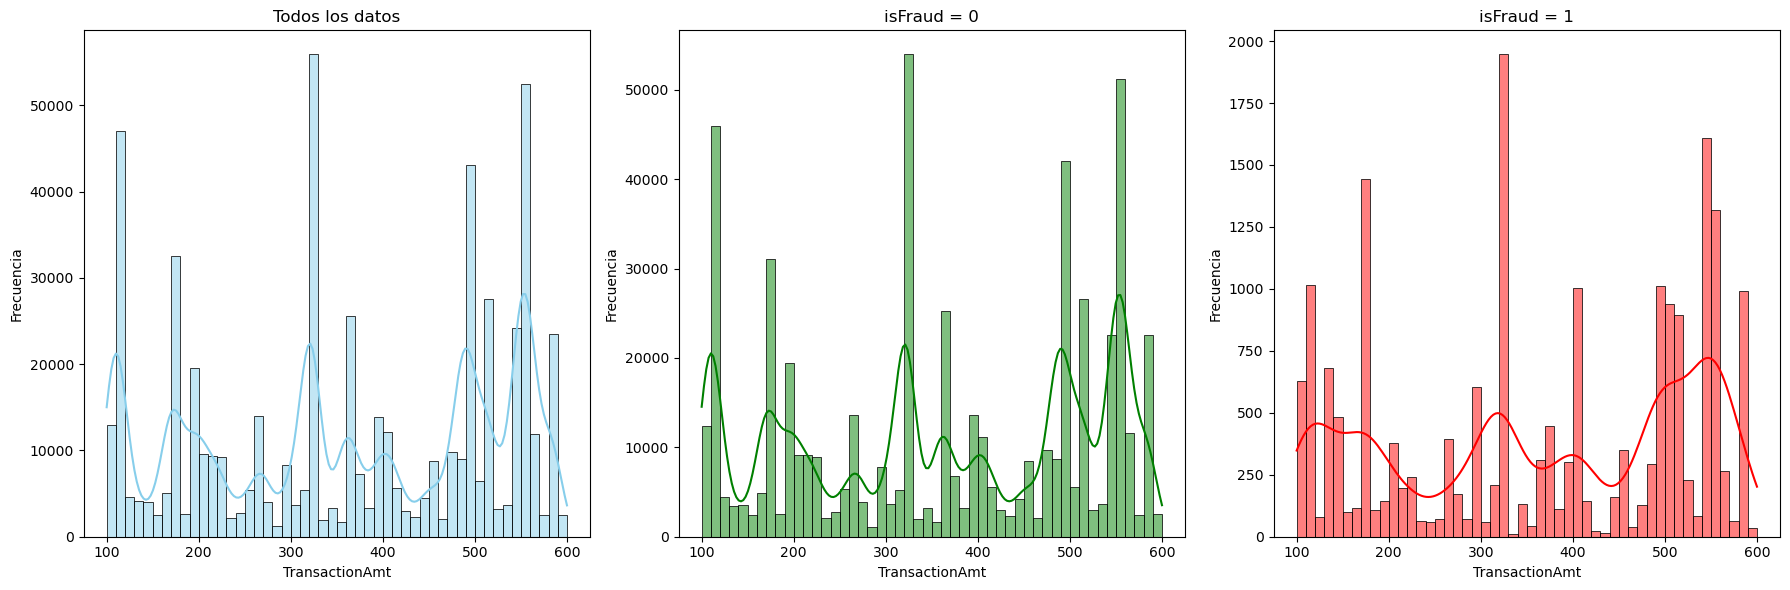

In [166]:
ig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_n_num["card2"], bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Todos los datos')
axes[0].set_xlabel('TransactionAmt')
axes[0].set_ylabel('Frecuencia')
#axes[0].set_xlim(140, 200)

# Histograma donde la columna isFraud = 0
sns.histplot(df_n_num[df_n_num["isFraud"] == False]["card2"], bins=50, kde=True, color='green', ax=axes[1])
axes[1].set_title('isFraud = 0')
axes[1].set_xlabel('TransactionAmt')
axes[1].set_ylabel('Frecuencia')
#axes[1].set_xlim(140, 200)

# Histograma donde la columna isFraud = 1
sns.histplot(df_n_num[df_n_num['isFraud'] == True]["card2"], bins=50, kde=True, color='red', ax=axes[2])
axes[2].set_title('isFraud = 1')
axes[2].set_xlabel('TransactionAmt')
axes[2].set_ylabel('Frecuencia')
#axes[2].set_xlim(140, 200)

plt.tight_layout()  
plt.show()

No se logra observar una clara distribucion o algun patron caracteristico en los datos, por ende no se puede inferir mucho a simple vista sobre la variable Card2.

Un arbol de regresion no es capaz de hacer

### Columnas Categoricas

In [180]:
df_n_cat

,Entity,card6,isFraud
1,MastC,True,False
2,Visa,False,False
3,MastC,False,False
4,MastC,True,False
5,Visa,False,False
...,...,...,...
590534,MastC,False,False
590536,MastC,False,False
590537,MastC,False,False
590538,MastC,False,False


In [182]:
total_count_by_category = df_n_cat.groupby('Entity').size()

# Contar el número de veces que 'True' aparece en 'Flag' por categoría
true_count_by_category = df_n_cat[df_n_cat['isFraud'] == False].groupby('Entity').size()

# Calcular la proporción de 'True' con respecto al total por categoría
proportion_by_category = true_count_by_category / total_count_by_category

print("Proporción de 'True' por categoría:")
print(proportion_by_category)

Proporción de 'True' por categoría:
Entity
AmExp    0.971004
Disc     0.914698
MastC    0.965635
Visa     0.965567
dtype: float64


Extrayendo la proporcion de datos no fraudulentos en la poblacion por cada posible valor de "Entity", tenemos que se presentan mayores fraudes para las tarjetas discovery y la que menos presenta fraudes es la american express

In [183]:
total_count_by_category = df_n_cat.groupby('card6').size()

# Contar el número de veces que 'True' aparece en 'Flag' por categoría
true_count_by_category = df_n_cat[df_n_cat['isFraud'] == False].groupby('card6').size()

# Calcular la proporción de 'True' con respecto al total por categoría
proportion_by_category = true_count_by_category / total_count_by_category

print("Proporción de 'True' por categoría:")
print(proportion_by_category)

Proporción de 'True' por categoría:
card6
False    0.975624
True     0.934146
dtype: float64


Los valores True de la variable Card6 presentan una proporcion mayor de transacciones fraudulentas que las de False.